#### Pre Processing

In [ ]:
import os
import re
import json
import pandas as pd
import nltk
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from typing import List
from IPython.display import display

# -------------------------
# Config paths
# -------------------------
INPUT_CSV = "scrapped_data_honkai_star_rail.csv"   # raw input
OUTPUT_FINAL = "hasil_preprocessing.csv"           # final cleaned file for modeling
JSONL_OUT = "preprocessed_full_with_lists.jsonl"
EMPTY_ROWS_OUT = "empty_rows_preprocessing.csv"
PREPOST_EMPTY_SAMPLE = "empty_after_preprocessing_sample.csv"
DUPLICATE_ROWS_OUT = "duplicate_rows_final.csv"
SAMPLES_DIR = "samples"
os.makedirs(SAMPLES_DIR, exist_ok=True)

# -------------------------
# NLTK safe-guard downloads
# -------------------------
nltk_packages = ["punkt", "stopwords"]
for pkg in nltk_packages:
    try:
        nltk.data.find(f"tokenizers/{pkg}")
    except Exception:
        nltk.download(pkg)

# -------------------------
# Load raw data and detect text column
# -------------------------
df_raw = pd.read_csv(INPUT_CSV)
possible_text_cols = ['review', 'content', 'comment', 'text', 'body', 'reviewBody']
TEXT_COL = next((c for c in possible_text_cols if c in df_raw.columns), None)
if TEXT_COL is None:
    raise ValueError(f"❌ Tidak ditemukan kolom teks di CSV. Kolom yang tersedia: {df_raw.columns.tolist()}")

# keep original index for traceability
df_raw = df_raw.reset_index().rename(columns={'index':'original_index'})
print(f"✅ Data mentah dimuat: {len(df_raw)} baris. Teks kolom: '{TEXT_COL}'")

# ----------------------------------------
# 0) Pre-filter: find and persist ALL empty occurrences (NaN or empty-string)
# ----------------------------------------
empty_nan = df_raw[df_raw[TEXT_COL].isna()]
empty_str = df_raw[df_raw[TEXT_COL].astype(str).str.strip() == ""]
empty_combined = pd.concat([empty_nan, empty_str]).drop_duplicates(subset=["original_index"])

print(f"Jumlah baris kosong (sebelum preprocessing): {len(empty_combined)} (NaN: {len(empty_nan)}, empty string: {len(empty_str)})")
# save sample and full list
empty_combined.to_csv(EMPTY_ROWS_OUT, index=False, encoding="utf-8-sig")
print(f"Saved: {EMPTY_ROWS_OUT}")
display(empty_combined.head(50))

# ----------------------------------------
# Prepare dataframe for preprocessing: exclude those empty rows (so pipeline not wasted)
# ----------------------------------------
df = df_raw[~df_raw["original_index"].isin(empty_combined["original_index"])].copy()
df = df.rename(columns={TEXT_COL: "content"})
df["content"] = df["content"].astype(str)   # safe cast
print(f"✅ Baris untuk diproses setelah mengeluarkan kosong: {len(df)}")

# -------------------------
# Normalization dictionary (non-baku -> baku)
# -------------------------
normalization_dict = {
    "ga": "tidak", "gak": "tidak", "gaada": "tidak ada", "gacha": "gacha", "pity": "pity", 
    "banner": "banner","bgt": "sekali", "aja": "saja", "jd": "jadi", "yg": "yang", "tpi": "tapi", 
    "bg": "bang", "sy": "saya","gk": "tidak", "dpt": "dapat", "bngt": "sekali", "lg": "lagi",
    "lgi":"lagi", "gw": "saya", "gue": "saya","lu": "kamu","udh": "sudah","udah": "sudah","mksih": "terima kasih", 
    "kalo": "kalau", "kyk": "seperti", "jg": "juga", "blm": "belum", "gmn": "bagaimana", "kek": "seperti",
    "knp": "kenapa", "trs": "terus", "sm": "sama", "cmn": "cuma","blum": "belum", "nyah": "nya",
    "lagih": "lagi","dapet": "dapat", "gem": "game", "relic": "relic", "bnyk": "banyak", 
    "bgtt": "sekali", "baiq": "baik","geme": "game","gim": "game", "heba": "hebat", "rame": "ramai",
    "mantep": "mantap", "muas": "puas", "pls": "please", "ny": "nya", "nitip": "menitip", "gakan": "tidak akan",
    "pw": "power", "tlonk": "tolong", "mw": "mau", "smoga": "semoga", "sma": "sama", "kayak": "seperti",
    "dlu": "dulu", "bgtu": "begitu","tros": "terus", "plis": "please", "gamenya": "game nya", 
    "makasih": "terima kasih", "blom": "belum","seru banget": "sangat seru", "seru bgt": "sangat seru",
    "mantap bgt": "sangat mantap","smua": "semua","adain": "adakan", "adainya": "adakan nya", 
    "dgn": "dengan", "dlm": "dalam", "hrus": "harus", "jgn": "jangan","jga": "juga", "jdi": "jadi", 
    "jgnlah": "janganlah", "kpn": "kapan", "krn": "karena", "lbh": "lebih","mksd": "maksud", 
    "msti": "mesti", "nnti": "nanti", "sblm": "sebelum", "sbg": "sebagai", "sblmnya": "sebelum nya",
    "smg": "semoga", "spt": "seperti", "syr": "saya", "syg": "sayang", "tkt": "takut", "trus": "terus", 
    "tlong":"tolong", "u/": "untuk", "utk": "untuk", "gamplay": "game play", "gameplay": "game play", 
    "banget": "sekali","gemnya": "game nya", "nolongin": "menolong", "nolong": "menolong", 
    "tolongin": "menolong", "kg":"tidak", "kgk": "tidak","kga":"tidak","kagak":"tidak","kaga":"tidak",
    "kagk":"tidak","ngak":"tidak","ngga":"tidak","nggak":"tidak","ngk":"tidak","tdk":"tidak",
    "tdak":"tidak", "trimakasih":"terima kasih", "trmksh":"terima kasih", "trmksih":"terima kasih",
    "ngerilis":"merilis","gg":"good game", "geming": "game","gemink":"game","gamink":"game",
    "hongkai":"honkai", "seruh":"seru","maksih":"terima kasih","dari":"dari", "bosen":"bosan",
    "bacot":"bicara","bacotin":"membicarakan","bacotinlah":"membicarakanlah", "ngotak":"berpikir",
    "ngasih":"memberi", "ngambil":"mengambil", "ngeluarin":"mengeluarkan","ngebug":"terjadi bug", 
    "ngelepasin":"melepaskan", "ngecas":"mengisi","ngebantu":"membantu","mntp":"mantap","ngefix":"memperbaiki",
    "ngeban":"memblokir","ngeblok":"memblokir","ngebanned":"diblokir","banned":"diblokir", "nunggu":"menunggu", 
    "ngumpulin":"mengumpulkan","bnget":"sekali", "bgtu":"begitu","snggat":"sangat","sngt": "sangat",
    "sbenernya":"sebenarnya","sebenernya":"sebenarnya","bgd":"banget", "bgs":"bagus", "kurng":"kurang",
    "krng":"kurang","krang":"kurang","slalu":"selalu", "smakin":"semakin", "syaratnya":"syarat nya", 
    "ketentuanya":"ketentuan nya", "app": "aplikasi","apani": "apa ini", "apaan":"apa", "apanya":"apa nya", 
    "ntar":"nanti", "ntr":"nanti","mager":"malas gerak", "nyerang":"menyerang","sya": "saya", 
    "sy":"saya", "kmu":"kamu", "km":"kamu", "klu":"kalau", "kl":"kalau", "klo":"kalau","klau":"kalau",
    "f p":"free to play","p w":"pay to win","lmyan":"lumayan","mayan":"lumayan","w":"saya",
    "mayanlah":"lumayanlah", "trlalu":"terlalu","ak":"aku","apk":"aplikasi", "pliss":"please",
    "plisss":"please","tlnk":"tolong","tolonk":"tolong", "bikin":"buat","emg":"memang", "gweh":"saya",
    "emang":"memang", "manteb":"mantap", "yng":"yang", "kasi":"kasih", "liat":"lihat", "takkan":"tidak akan",
    "pas":"ketika", "kalok": "kalau","knapa":"kenapa","donlot": "unduh", "knpa":"kenapa","dah":"sudah","dh":"sudah",
    "capek":"lelah","g":"tidak", "matiin":"mematikan","thx":"thanks", "banyakin": "perbanyak",
    "gatau":"tidak tahu", "gk tau":"tidak tahu", "gk tahu":"tidak tahu", "ngapain":"mengapa",
    "sangt":"sangat", "gud":"good", "nyari": "mencari", "nyampe": "sampai", "ngelewatin": "melewati",
    "ku kira":"kukira","ampe":"sampai","tambahin":"tambahkan","buatin":"buatkan", "gampang":"mudah",
    "gampangin":"permudah","gampangan":"kemudahan","bosenin":"membuat bosan","bosenan":"kebosanan",
    "ngelakuin":"melakukan","ngelanjutin":"melanjutkan","lanjutin":"melanjutkan","ngatasin":"mengatasi",
    "dapetin":"mendapatkan", "storynya":"cerita nya", "mantab":"mantap", "mulu":"terus",
}

# -------------------------
# Stopwords & Stemmer
# -------------------------
stop_words_id = set(stopwords.words('indonesian'))
stop_words_en = set(stopwords.words('english'))
additional_stopwords = {
    "game", "nya", "sih", "aja", "yang", "gw", "gua","gwe", "gue", "kak", "min", "makasih", "huh",
    "terimakasih", "keren", "ok", "tolong", "mohon", "banget", "si", "bagus","ko", "kok", "hah",
    "mantap", "gamenya", "okelah", "thanks", "good", "nice", "best", "seru", "oke", "hp",
    "terima", "kasih", "semangat", "moga", "thank", "you", "please", "main", "lah", "lh"
    "baik", "ya", "sehat", "hoyoverse", "coy", "love", "ni", "suck", "like", "make", "play"
}
stop_words = stop_words_id.union(stop_words_en).union(additional_stopwords)

factory = StemmerFactory()
stemmer = factory.create_stemmer()

# -------------------------
# Utilities
# -------------------------
def case_folding(text: str) -> str:
    return str(text).lower()

def clean_text(text: str) -> str:
    text = str(text).replace("\u00A0", " ")
    text = re.sub(r"http\S+|www\.\S+", " ", text)
    text = re.sub(r"[^0-9A-Za-z\u00C0-\u024F\s]", " ", text)
    text = re.sub(r"[_\d]+", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

def normalize_text(text: str) -> str:
    words = text.split()
    words = [normalization_dict.get(w, w) for w in words]
    return " ".join(words)

def tokenize_text(text: str) -> List[str]:
    return re.findall(r'\b[^\d\W_]+\b', str(text), flags=re.UNICODE)

def remove_stopwords(tokens: List[str]) -> List[str]:
    return [t for t in tokens if t not in stop_words]

def stem_tokens(tokens: List[str]) -> List[str]:
    return [stemmer.stem(t) for t in tokens]

# helper for showing changes
def is_changed(a, b):
    if isinstance(a, list) and isinstance(b, list):
        return " ".join(a).strip() != " ".join(b).strip()
    return str(a).strip() != str(b).strip()

def show_step_examples(df_work: pd.DataFrame, before_col: str, after_col: str, top_n: int = 5):
    changed_mask = df_work.apply(lambda row: is_changed(row[before_col], row[after_col]), axis=1)
    changed_count = int(changed_mask.sum())
    print(f"\n--- Tahap: {before_col} → {after_col} | Baris berubah: {changed_count} dari {len(df_work)} ---")
    if changed_count == 0:
        print("Tidak ada perubahan pada tahap ini.")
        return
    samples = df_work[changed_mask].head(top_n).copy()
    def to_display(x):
        if isinstance(x, list):
            return " ".join(x)
        return x
    samples_display = samples[["original_index", "content", before_col, after_col]].copy()
    samples_display[before_col] = samples_display[before_col].apply(to_display)
    samples_display[after_col] = samples_display[after_col].apply(to_display)
    display(samples_display.reset_index(drop=True))

# -------------------------
# Run pipeline step-by-step (on df)
# -------------------------
df["raw_content"] = df["content"].astype(str)
df_raw_samples_path = os.path.join(SAMPLES_DIR, "sample_raw.csv")
df[["original_index","raw_content"]].to_csv(df_raw_samples_path, index=False, encoding="utf-8-sig")

# 1) case folding
df["case_folding"] = df["raw_content"].apply(case_folding)
show_step_examples(df, "raw_content", "case_folding", top_n=5)
df[["original_index","raw_content","case_folding"]].to_csv(os.path.join(SAMPLES_DIR, "sample_case_folding.csv"), index=False, encoding="utf-8-sig")

# 2) cleaning
df["cleaned"] = df["case_folding"].apply(clean_text)
show_step_examples(df, "case_folding", "cleaned", top_n=5)
df[["original_index","case_folding","cleaned"]].to_csv(os.path.join(SAMPLES_DIR, "sample_cleaned.csv"), index=False, encoding="utf-8-sig")

# 3) normalization
df["normalized"] = df["cleaned"].apply(normalize_text)
show_step_examples(df, "cleaned", "normalized", top_n=5)
df[["original_index","cleaned","normalized"]].to_csv(os.path.join(SAMPLES_DIR, "sample_normalized.csv"), index=False, encoding="utf-8-sig")

# 4) tokenize -> keep as list for preview
df["token"] = df["normalized"].apply(tokenize_text)
df["token_display"] = df["token"]
display(df[["original_index","normalized","token_display"]].head(10))
token_sample_csv = os.path.join(SAMPLES_DIR, "sample_tokenize_with_json.csv")
df["token_json"] = df["token"].apply(lambda x: json.dumps(x, ensure_ascii=False))
df[["original_index","normalized","token_json"]].to_csv(token_sample_csv, index=False, encoding="utf-8-sig")

# 5) remove stopwords
df["no_stopword"] = df["token"].apply(remove_stopwords)
show_step_examples(df, "token", "no_stopword", top_n=5)
df[["original_index","token","no_stopword"]].to_csv(os.path.join(SAMPLES_DIR, "sample_no_stopword.csv"), index=False, encoding="utf-8-sig")

# 6) stemming
df["stemmed"] = df["no_stopword"].apply(stem_tokens)
show_step_examples(df, "no_stopword", "stemmed", top_n=5)
df[["original_index","no_stopword","stemmed"]].to_csv(os.path.join(SAMPLES_DIR, "sample_stemmed.csv"), index=False, encoding="utf-8-sig")

# 7) final join -> clean_final is STRING for downstream
df["clean_final"] = df["stemmed"].apply(lambda x: " ".join(x) if isinstance(x, list) else str(x))
show_step_examples(df, "stemmed", "clean_final", top_n=5)
df[["original_index","stemmed","clean_final"]].to_csv(os.path.join(SAMPLES_DIR, "sample_clean_final.csv"), index=False, encoding="utf-8-sig")

# -------------------------
# Filter out those that became empty after preprocessing (transparency: save sample & full list)
# -------------------------
before_filter_count = len(df)
mask_empty_after = df["clean_final"].astype(str).str.strip() == ""
df_empty_after = df[mask_empty_after].copy()
if len(df_empty_after) > 0:
    print(f"\n⚠️ Baris yang menjadi kosong setelah preprocessing: {len(df_empty_after)} (akan dibuang dari hasil akhir).")
    df_empty_after[["original_index","content","clean_final"]].head(200).to_csv(PREPOST_EMPTY_SAMPLE, index=False, encoding="utf-8-sig")
    print(f"Saved sample of removed-after-preprocessing -> {PREPOST_EMPTY_SAMPLE}")
    display(df_empty_after.head(50))
# keep only non-empty clean_final
df = df[~mask_empty_after].copy()
after_filter_count = len(df)
print(f"\n✅ Setelah preprocessing + filter empty: tersisa {after_filter_count} ulasan dari {before_filter_count} (dibuang {before_filter_count - after_filter_count})")

# -------------------------
# Deduplicate final set based on clean_final (keep first) — this avoids near-exact duplicate texts in modeling
# and also keep traceability to original_index
# -------------------------
df_no_dup = df.drop_duplicates(subset=["clean_final"], keep="first").reset_index(drop=True)
dups_final = df[df.duplicated(subset=["clean_final"], keep=False)].sort_values("clean_final")
print(f"\nJumlah baris final yang termasuk duplikat (semua occurrence) pada 'clean_final': {len(dups_final)}")
if len(dups_final) > 0:
    # save duplicates for inspection
    dups_final[["original_index","content","clean_final"]].to_csv(DUPLICATE_ROWS_OUT, index=False, encoding="utf-8-sig")
    print(f"Saved duplicate rows (final) -> {DUPLICATE_ROWS_OUT}")
    display(dups_final.head(50))

# -------------------------
# Save final outputs
# -------------------------
df_out = df_no_dup[["original_index","content","clean_final"]].copy()
df_out.to_csv(OUTPUT_FINAL, index=False, encoding="utf-8-sig")
print(f"\n✅ Hasil preprocessing lengkap (tanpa duplikat pada clean_final) disimpan ke '{OUTPUT_FINAL}'")

with open(JSONL_OUT, "w", encoding="utf-8") as f:
    for rec in df_no_dup.to_dict(orient="records"):
        f.write(json.dumps(rec, ensure_ascii=False) + "\n")
print(f"✅ Saved full JSONL (preserve list types where present) -> {JSONL_OUT}")

print("\n📁 Semua sample dan keluaran terkait disimpan di folder:", SAMPLES_DIR)
print("- empty_rows_preprocessing.csv : semua baris yang kosong sebelum preprocessing")
print("- preprocessed_full_with_lists.jsonl : jsonl lengkap")
print("- duplicate_rows_final.csv : semua occurrence duplikat berdasarkan clean_final (jika ada)")
print("- hasil_preprocessing.csv : file akhir untuk modeling (clean_final string)")

# quick notes
print("\nCatatan:")
print("- Script ini mengeluarkan baris kosong di awal agar pipeline tidak memproses teks kosong.")
print("- Masih menampilkan & menyimpan contoh baris yang akan/have been removed agar transparan.")
print("- Deduplication dilakukan di level `clean_final` agar duplikat bermakna ditangani setelah preprocessing.")


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


✅ Data mentah dimuat: 25413 baris. Teks kolom: 'content'
Jumlah baris kosong (sebelum preprocessing): 0 (NaN: 0, empty string: 0)
Saved: empty_rows_preprocessing.csv


,original_index,userName,score,at,content


✅ Baris untuk diproses setelah mengeluarkan kosong: 25413

--- Tahap: raw_content → case_folding | Baris berubah: 19092 dari 25413 ---


,original_index,content,raw_content,case_folding
0,0,udah warp 140 kali masih blum dapat B5 yg ada ...,udah warp 140 kali masih blum dapat B5 yg ada ...,udah warp 140 kali masih blum dapat b5 yg ada ...
1,1,"Bagus game hoyo versi turn base, banyak bansos...","Bagus game hoyo versi turn base, banyak bansos...","bagus game hoyo versi turn base, banyak bansos..."
2,2,"bagus, tapi semenjak update besar bngt GB nya","bagus, tapi semenjak update besar bngt GB nya","bagus, tapi semenjak update besar bngt gb nya"
3,3,global passive? HP inflation? pfft* hell no,global passive? HP inflation? pfft* hell no,global passive? hp inflation? pfft* hell no
4,6,"Buat game ini jadi seimbang, jangan buat chara...","Buat game ini jadi seimbang, jangan buat chara...","buat game ini jadi seimbang, jangan buat chara..."



--- Tahap: case_folding → cleaned | Baris berubah: 14464 dari 25413 ---


,original_index,content,case_folding,cleaned
0,0,udah warp 140 kali masih blum dapat B5 yg ada ...,udah warp 140 kali masih blum dapat b5 yg ada ...,udah warp kali masih blum dapat b yg ada di ba...
1,1,"Bagus game hoyo versi turn base, banyak bansos...","bagus game hoyo versi turn base, banyak bansos...",bagus game hoyo versi turn base banyak bansos ...
2,2,"bagus, tapi semenjak update besar bngt GB nya","bagus, tapi semenjak update besar bngt gb nya",bagus tapi semenjak update besar bngt gb nya
3,3,global passive? HP inflation? pfft* hell no,global passive? hp inflation? pfft* hell no,global passive hp inflation pfft hell no
4,4,game nyah sudah saya hapus susah gacha nyah ap...,game nyah sudah saya hapus susah gacha nyah ap...,game nyah sudah saya hapus susah gacha nyah ap...



--- Tahap: cleaned → normalized | Baris berubah: 10992 dari 25413 ---


,original_index,content,cleaned,normalized
0,0,udah warp 140 kali masih blum dapat B5 yg ada ...,udah warp kali masih blum dapat b yg ada di ba...,sudah warp kali masih belum dapat b yang ada d...
1,1,"Bagus game hoyo versi turn base, banyak bansos...",bagus game hoyo versi turn base banyak bansos ...,bagus game hoyo versi turn base banyak bansos ...
2,2,"bagus, tapi semenjak update besar bngt GB nya",bagus tapi semenjak update besar bngt gb nya,bagus tapi semenjak update besar sekali gb nya
3,4,game nyah sudah saya hapus susah gacha nyah ap...,game nyah sudah saya hapus susah gacha nyah ap...,game nya sudah saya hapus susah gacha nya apa ...
4,5,"ga jelas bgt siii, masa pas story di tempat be...",ga jelas bgt siii masa pas story di tempat ber...,tidak jelas sekali siii masa ketika story di t...


,original_index,normalized,token_display
0,0,sudah warp kali masih belum dapat b yang ada d...,"[sudah, warp, kali, masih, belum, dapat, b, ya..."
1,1,bagus game hoyo versi turn base banyak bansos ...,"[bagus, game, hoyo, versi, turn, base, banyak,..."
2,2,bagus tapi semenjak update besar sekali gb nya,"[bagus, tapi, semenjak, update, besar, sekali,..."
3,3,global passive hp inflation pfft hell no,"[global, passive, hp, inflation, pfft, hell, no]"
4,4,game nya sudah saya hapus susah gacha nya apa ...,"[game, nya, sudah, saya, hapus, susah, gacha, ..."
5,5,tidak jelas sekali siii masa ketika story di t...,"[tidak, jelas, sekali, siii, masa, ketika, sto..."
6,6,buat game ini jadi seimbang jangan buat charac...,"[buat, game, ini, jadi, seimbang, jangan, buat..."
7,7,walaupun hampir semua nya chara b tapi hsr mas...,"[walaupun, hampir, semua, nya, chara, b, tapi,..."
8,8,tolong adakan karakter pacarku dia mau jadi an...,"[tolong, adakan, karakter, pacarku, dia, mau, ..."
9,9,game jahat stellar k ku hilang di makan bailu ...,"[game, jahat, stellar, k, ku, hilang, di, maka..."



--- Tahap: token → no_stopword | Baris berubah: 22581 dari 25413 ---


,original_index,content,token,no_stopword
0,0,udah warp 140 kali masih blum dapat B5 yg ada ...,sudah warp kali masih belum dapat b yang ada d...,warp kali b banernya clara warp sisa b mulu su...
1,1,"Bagus game hoyo versi turn base, banyak bansos...",bagus game hoyo versi turn base banyak bansos ...,hoyo versi turn base bansos kekurangan gacha r...
2,2,"bagus, tapi semenjak update besar bngt GB nya",bagus tapi semenjak update besar sekali gb nya,semenjak update gb
3,3,global passive? HP inflation? pfft* hell no,global passive hp inflation pfft hell no,global passive inflation pfft hell
4,4,game nyah sudah saya hapus susah gacha nyah ap...,game nya sudah saya hapus susah gacha nya apa ...,hapus susah gacha free mencari mengumpulkan ke...



--- Tahap: no_stopword → stemmed | Baris berubah: 9603 dari 25413 ---


,original_index,content,no_stopword,stemmed
0,1,"Bagus game hoyo versi turn base, banyak bansos...",hoyo versi turn base bansos kekurangan gacha r...,hoyo versi turn base bansos kurang gacha relic...
1,4,game nyah sudah saya hapus susah gacha nyah ap...,hapus susah gacha free mencari mengumpulkan ke...,hapus susah gacha free cari kumpul keburu habi...
2,5,"ga jelas bgt siii, masa pas story di tempat be...",siii story bersalju menolong orang nge stuck b...,siii story salju tolong orang nge stuck black ...
3,6,"Buat game ini jadi seimbang, jangan buat chara...",seimbang character terpakai,imbang character pakai
4,8,"tlonk adain karakter pacarku, dia mw jadi anak...",adakan karakter pacarku anak kesayangan,adakan karakter pacar anak sayang



--- Tahap: stemmed → clean_final | Baris berubah: 25413 dari 25413 ---


,original_index,content,stemmed,clean_final
0,0,udah warp 140 kali masih blum dapat B5 yg ada ...,warp kali b banernya clara warp sisa b mulu su...,warp kali b banernya clara warp sisa b mulu su...
1,1,"Bagus game hoyo versi turn base, banyak bansos...",hoyo versi turn base bansos kurang gacha relic...,hoyo versi turn base bansos kurang gacha relic...
2,2,"bagus, tapi semenjak update besar bngt GB nya",semenjak update gb,semenjak update gb
3,3,global passive? HP inflation? pfft* hell no,global passive inflation pfft hell,global passive inflation pfft hell
4,4,game nyah sudah saya hapus susah gacha nyah ap...,hapus susah gacha free cari kumpul keburu habi...,hapus susah gacha free cari kumpul keburu habi...



⚠️ Baris yang menjadi kosong setelah preprocessing: 4040 (akan dibuang dari hasil akhir).
Saved sample of removed-after-preprocessing -> empty_after_preprocessing_sample.csv


,original_index,userName,score,at,content,raw_content,case_folding,cleaned,normalized,token,token_display,token_json,no_stopword,stemmed,clean_final
11,11,Pengguna Google,1,2025-04-27 11:09:49,bagus gemnya,bagus gemnya,bagus gemnya,bagus gemnya,bagus game nya,"[bagus, game, nya]","[bagus, game, nya]","[""bagus"", ""game"", ""nya""]",[],[],
50,50,Pengguna Google,5,2025-04-25 21:23:05,Game baik,Game baik,game baik,game baik,game baik,"[game, baik]","[game, baik]","[""game"", ""baik""]",[],[],
68,68,Pengguna Google,5,2025-04-24 18:37:50,mantap,mantap,mantap,mantap,mantap,[mantap],[mantap],"[""mantap""]",[],[],
74,74,Pengguna Google,5,2025-04-24 11:35:21,thanks game baik,thanks game baik,thanks game baik,thanks game baik,thanks game baik,"[thanks, game, baik]","[thanks, game, baik]","[""thanks"", ""game"", ""baik""]",[],[],
76,76,Pengguna Google,5,2025-04-24 08:41:29,bagus,bagus,bagus,bagus,bagus,[bagus],[bagus],"[""bagus""]",[],[],
86,86,Pengguna Google,5,2025-04-23 20:19:47,￶‍,￶‍,￶‍,,,[],[],[],[],[],
93,93,Pengguna Google,5,2025-04-23 12:31:39,thanks game baik,thanks game baik,thanks game baik,thanks game baik,thanks game baik,"[thanks, game, baik]","[thanks, game, baik]","[""thanks"", ""game"", ""baik""]",[],[],
94,94,Pengguna Google,5,2025-04-23 12:13:39,game nya bagus banget,game nya bagus banget,game nya bagus banget,game nya bagus banget,game nya bagus sekali,"[game, nya, bagus, sekali]","[game, nya, bagus, sekali]","[""game"", ""nya"", ""bagus"", ""sekali""]",[],[],
95,95,Pengguna Google,5,2025-04-23 11:38:19,game baiq,game baiq,game baiq,game baiq,game baik,"[game, baik]","[game, baik]","[""game"", ""baik""]",[],[],
104,104,Pengguna Google,5,2025-04-22 23:07:53,game baik,game baik,game baik,game baik,game baik,"[game, baik]","[game, baik]","[""game"", ""baik""]",[],[],



✅ Setelah preprocessing + filter empty: tersisa 21373 ulasan dari 25413 (dibuang 4040)

Jumlah baris final yang termasuk duplikat (semua occurrence) pada 'clean_final': 3689
Saved duplicate rows (final) -> duplicate_rows_final.csv


,original_index,userName,score,at,content,raw_content,case_folding,cleaned,normalized,token,token_display,token_json,no_stopword,stemmed,clean_final
11581,11581,Pengguna Google,5,2024-04-24 13:29:22,game nya seru abiss!!,game nya seru abiss!!,game nya seru abiss!!,game nya seru abiss,game nya seru abiss,"[game, nya, seru, abiss]","[game, nya, seru, abiss]","[""game"", ""nya"", ""seru"", ""abiss""]",[abiss],[abiss],abiss
23812,23812,Pengguna Google,5,2023-04-26 20:37:43,Keren abiss,Keren abiss,keren abiss,keren abiss,keren abiss,"[keren, abiss]","[keren, abiss]","[""keren"", ""abiss""]",[abiss],[abiss],abiss
2886,2886,Pengguna Google,5,2025-04-07 19:16:28,"Nice game, ABSOLUTE CINEMA✋😧🤚","Nice game, ABSOLUTE CINEMA✋😧🤚","nice game, absolute cinema✋😧🤚",nice game absolute cinema,nice game absolute cinema,"[nice, game, absolute, cinema]","[nice, game, absolute, cinema]","[""nice"", ""game"", ""absolute"", ""cinema""]","[absolute, cinema]","[absolute, cema]",absolute cema
5569,5569,Pengguna Google,5,2025-03-15 01:25:12,ABSOLUTE CINEMA,ABSOLUTE CINEMA,absolute cinema,absolute cinema,absolute cinema,"[absolute, cinema]","[absolute, cinema]","[""absolute"", ""cinema""]","[absolute, cinema]","[absolute, cema]",absolute cema
141,141,Pengguna Google,5,2025-04-21 13:29:21,Just Absolute Cinema,Just Absolute Cinema,just absolute cinema,just absolute cinema,just absolute cinema,"[just, absolute, cinema]","[just, absolute, cinema]","[""just"", ""absolute"", ""cinema""]","[absolute, cinema]","[absolute, cema]",absolute cema
402,402,Pengguna Google,5,2025-04-15 08:29:39,absolute cinema ✋😎🤚,absolute cinema ✋😎🤚,absolute cinema ✋😎🤚,absolute cinema,absolute cinema,"[absolute, cinema]","[absolute, cinema]","[""absolute"", ""cinema""]","[absolute, cinema]","[absolute, cema]",absolute cema
5831,5831,Pengguna Google,5,2025-02-26 16:00:27,Absolute cinema ✋😐🤚,Absolute cinema ✋😐🤚,absolute cinema ✋😐🤚,absolute cinema,absolute cinema,"[absolute, cinema]","[absolute, cinema]","[""absolute"", ""cinema""]","[absolute, cinema]","[absolute, cema]",absolute cema
117,117,Pengguna Google,5,2025-04-22 08:05:13,absolute cinema,absolute cinema,absolute cinema,absolute cinema,absolute cinema,"[absolute, cinema]","[absolute, cinema]","[""absolute"", ""cinema""]","[absolute, cinema]","[absolute, cema]",absolute cema
5574,5574,Pengguna Google,5,2025-03-14 20:17:01,Absolute cinema,Absolute cinema,absolute cinema,absolute cinema,absolute cinema,"[absolute, cinema]","[absolute, cinema]","[""absolute"", ""cinema""]","[absolute, cinema]","[absolute, cema]",absolute cema
6625,6625,Pengguna Google,5,2025-01-10 14:25:46,Absolute Cinema,Absolute Cinema,absolute cinema,absolute cinema,absolute cinema,"[absolute, cinema]","[absolute, cinema]","[""absolute"", ""cinema""]","[absolute, cinema]","[absolute, cema]",absolute cema



✅ Hasil preprocessing lengkap (tanpa duplikat pada clean_final) disimpan ke 'hasil_preprocessing.csv'
✅ Saved full JSONL (preserve list types where present) -> preprocessed_full_with_lists.jsonl

📁 Semua sample dan keluaran terkait disimpan di folder: samples
- empty_rows_preprocessing.csv : semua baris yang kosong sebelum preprocessing
- preprocessed_full_with_lists.jsonl : jsonl lengkap
- duplicate_rows_final.csv : semua occurrence duplikat berdasarkan clean_final (jika ada)
- hasil_preprocessing.csv : file akhir untuk modeling (clean_final string)

Catatan:
- Script ini mengeluarkan baris kosong di awal agar pipeline tidak memproses teks kosong.
- Masih menampilkan & menyimpan contoh baris yang akan/have been removed agar transparan.
- Deduplication dilakukan di level `clean_final` agar duplikat bermakna ditangani setelah preprocessing.


### pipeline Data Mining, Evaluasi, Visualisasi

1) Memuat data preprocessing...
   Jumlah dokumen: 18377
2) Parameter otomatis:
   min_df: 0.0015
   max_df: 0.8
   n_neighbors: 35
   n_components: 5
   min_cluster_size: 55
   min_samples: 18
3) Mengecek vocabulary CountVectorizer...
   Vocabulary size: 919
4) Menyiapkan embedding IndoBERT...
   Menggunakan model lokal: ./model/indobert-base-p1


2025-12-02 15:08:13,502 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm


   Memuat embeddings dari cache: emb_cache\embeddings_18377.npy
5) Menyiapkan UMAP dan HDBSCAN...
6) Membuat objek BERTopic...
   Melatih model (fit_transform)...


2025-12-02 15:09:17,844 - BERTopic - Dimensionality - Completed ✓
2025-12-02 15:09:17,853 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-12-02 15:09:37,896 - BERTopic - Cluster - Completed ✓
2025-12-02 15:09:37,912 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-12-02 15:09:39,769 - BERTopic - Representation - Completed ✓


   Selesai. Waktu pelatihan: 1.45 menit
   Topik efektif: 38
   Proporsi outlier: 68.72%
7) Ringkasan distribusi topik (tanpa outlier)...
   Topic 0: 734 dokumen (12.77% dari non-outlier)
   Topic 1: 329 dokumen (5.72% dari non-outlier)
   Topic 2: 312 dokumen (5.43% dari non-outlier)
   Topic 3: 305 dokumen (5.31% dari non-outlier)
   Topic 4: 265 dokumen (4.61% dari non-outlier)
   Topic 5: 243 dokumen (4.23% dari non-outlier)
   Topic 6: 232 dokumen (4.04% dari non-outlier)
   Topic 7: 208 dokumen (3.62% dari non-outlier)
   Topic 8: 206 dokumen (3.58% dari non-outlier)
   Topic 9: 195 dokumen (3.39% dari non-outlier)

   >>> Topic terbesar: #0 dengan 734 dokumen (~12.77% dari non-outlier)
   Jika persentase ini > 40%, pertimbangkan menurunkan 'min_cluster_size' sedikit atau pakai dataset sample dulu.

8) Menghitung skor koherensi per topik (c_v)...
   Mean coherence (c_v) topik valid: 0.6655
9) Menyimpan representasi c-TF-IDF per topik...
   File c-TF-IDF disimpan.
10A) Membuat bar

   Barchart topik disimpan sebagai HTML.
10B) Membuat intertopic distance map...


   Intertopic distance map disimpan sebagai HTML.
11) WordCloud global (sebaran kata keseluruhan topik)...


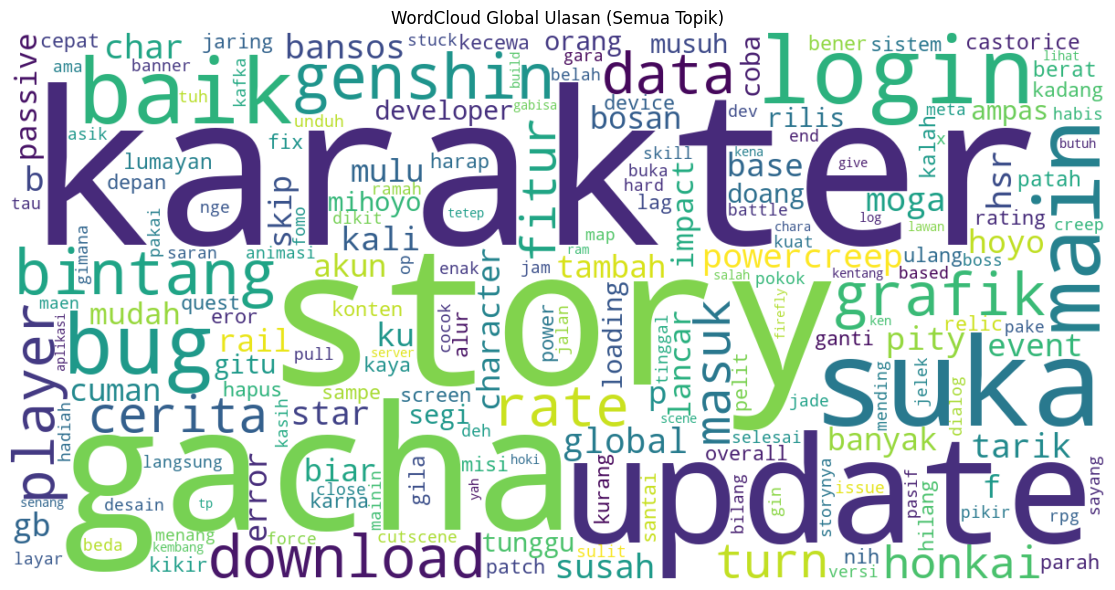

   WordCloud global disimpan ke: Hasil\wordcloud_global.png
12) Menyimpan topic_info & assignments...

===== RINGKASAN AKHIR =====
Jumlah dokumen           : 18377
Topik efektif (Topic!=-1): 38
Proporsi outlier         : 68.72%
Mean coherence (c_v)     : 0.6655
Topik terbesar #0 share non-outlier: 12.77%
Output utama tersimpan di folder: Hasil/


In [ ]:
"""
TOPIC MODELING PIPELINE (IndoBERT + BERTopic)
- Fokus: jumlah topik cukup, outlier sedang
- Mengurangi risiko topik numpuk di Topic #0
- Evaluasi: coherence (c_v), c-TF-IDF
- Visualisasi: intertopic distance map + barchart + wordcloud global
"""

import os
import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

from sentence_transformers import SentenceTransformer
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
from umap import UMAP
from hdbscan import HDBSCAN
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
from wordcloud import WordCloud

# ----------------------- KONFIGURASI -----------------------
PREPROCESSED_PATH = "hasil_preprocessing.csv"   # file hasil preprocessing
OUTPUT_DIR = "Hasil"
EMB_CACHE_DIR = "emb_cache"
LOCAL_INDOBERT_PATH = "./model/indobert-base-p1"  # kalau tidak ada, akan ambil dari HF
BATCH_SIZE = 32       # bisa dinaikkan jika RAM/GPU kuat
SAVE_PLOTLY_PNG = False  # kalau mau PNG dari plotly, install kaleido

os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(EMB_CACHE_DIR, exist_ok=True)

# ----------------------- 1. LOAD DATA ----------------------
print("1) Memuat data preprocessing...")
if not os.path.exists(PREPROCESSED_PATH):
    raise FileNotFoundError(f"File tidak ditemukan: {PREPROCESSED_PATH}")

df = pd.read_csv(PREPROCESSED_PATH, dtype=str)
if "clean_final" not in df.columns:
    raise ValueError("Kolom 'clean_final' tidak ditemukan. Cek kembali hasil preprocessing.")

docs = df["clean_final"].astype(str).tolist()
N = len(docs)
print(f"   Jumlah dokumen: {N}")

# ----------------------- 2. AUTO PARAM ---------------------
def auto_param_rules(n_docs: int):
    """
    Mengatur parameter supaya:
    - topik tidak kebanyakan
    - outlier sedang
    - mengurangi kemungkinan 1 topik super besar
    """
    if n_docs < 3000:
        min_df = 2
        max_df = 0.95
        n_neighbors = 15
        n_components = 5
        min_cluster_size = max(5, int(0.01 * n_docs))
        min_samples = max(5, int(min_cluster_size / 3))
    elif n_docs < 7000:
        min_df = max(2, int(0.002 * n_docs))
        max_df = 0.9
        n_neighbors = 20
        n_components = 5
        min_cluster_size = max(10, int(0.006 * n_docs))  # sedikit dinaikkan
        min_samples = max(5, int(min_cluster_size / 3))
    else:
        # skenario dataset besar (~18k)
        min_df = 0.0015      # 0.15% dokumen
        max_df = 0.8
        # n_neighbors agak moderat; terlalu besar bikin cluster terlalu sedikit
        n_neighbors = 35
        n_components = 5
        # min_cluster_size sekitar 0.003 * N (kurang-lebih)
        min_cluster_size = max(45, int(0.003 * n_docs))   # ~55–60 untuk 18k
        min_samples = max(10, int(min_cluster_size / 3))  # sekitar 18–20
    return {
        "min_df": min_df,
        "max_df": max_df,
        "n_neighbors": n_neighbors,
        "n_components": n_components,
        "min_cluster_size": min_cluster_size,
        "min_samples": min_samples
    }

params = auto_param_rules(N)
print("2) Parameter otomatis:")
for k, v in params.items():
    print(f"   {k}: {v}")

# ----------------------- 3. CountVectorizer aman --------------------
def make_vectorizer(min_df, max_df, ngram=(1,2)):
    if isinstance(min_df, float):
        min_df_frac = float(min_df)
        if min_df_frac >= float(max_df):
            min_df_frac = float(max_df) / 10.0
        vect = CountVectorizer(
            ngram_range=ngram,
            min_df=min_df_frac,
            max_df=float(max_df)
        )
    else:
        min_df_int = int(min_df)
        max_df_frac = float(max_df)
        if max_df_frac <= (min_df_int / max(1, N)):
            max_df_frac = min(0.95, (min_df_int / N) + 0.05)
        vect = CountVectorizer(
            ngram_range=ngram,
            min_df=min_df_int,
            max_df=max_df_frac
        )
    return vect

vectorizer = make_vectorizer(params["min_df"], params["max_df"], ngram=(1,2))

# cek vocab supaya tidak kosong
print("3) Mengecek vocabulary CountVectorizer...")
_ = vectorizer.fit(docs)
vocab_size = len(vectorizer.get_feature_names_out())
print(f"   Vocabulary size: {vocab_size}")
if vocab_size == 0:
    raise ValueError("Vocabulary kosong. Turunkan min_df atau ubah ngram_range.")

# ----------------------- 4. Embedding (cache) -----------------------
print("4) Menyiapkan embedding IndoBERT...")
if os.path.exists(LOCAL_INDOBERT_PATH):
    print(f"   Menggunakan model lokal: {LOCAL_INDOBERT_PATH}")
    embedding_model = SentenceTransformer(LOCAL_INDOBERT_PATH)
else:
    print("   Mengunduh model: indobenchmark/indobert-base-p1")
    embedding_model = SentenceTransformer("indobenchmark/indobert-base-p1")

emb_cache_path = os.path.join(EMB_CACHE_DIR, f"embeddings_{N}.npy")
if os.path.exists(emb_cache_path):
    print(f"   Memuat embeddings dari cache: {emb_cache_path}")
    embeddings = np.load(emb_cache_path)
else:
    print("   Menghitung embeddings (batch_size =", BATCH_SIZE, ") ...")
    embeddings = embedding_model.encode(docs, batch_size=BATCH_SIZE, show_progress_bar=True)
    np.save(emb_cache_path, embeddings)
    print("   Embeddings disimpan ke:", emb_cache_path)

# ----------------------- 5. UMAP & HDBSCAN --------------------------
print("5) Menyiapkan UMAP dan HDBSCAN...")
umap_model = UMAP(
    n_neighbors=params["n_neighbors"],
    n_components=params["n_components"],
    metric="cosine",
    min_dist=0.05,
    random_state=42
)

hdbscan_model = HDBSCAN(
    min_cluster_size=params["min_cluster_size"],
    min_samples=params["min_samples"],
    metric="euclidean",              # UMAP output pakai euclidean
    prediction_data=True,
    cluster_selection_method="leaf"  # lebih granular → mengurangi 1 cluster superbesar
)

# ----------------------- 6. BERTopic -------------------------------
print("6) Membuat objek BERTopic...")
topic_model = BERTopic(
    embedding_model=embedding_model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    vectorizer_model=vectorizer,
    language="multilingual",
    calculate_probabilities=True,
    verbose=True
)

print("   Melatih model (fit_transform)...")
start = time.time()
topics, probs = topic_model.fit_transform(docs, embeddings=embeddings)
elapsed = (time.time() - start) / 60.0
print(f"   Selesai. Waktu pelatihan: {elapsed:.2f} menit")

topic_info = topic_model.get_topic_info()
num_effective_topics = len(topic_info[topic_info["Topic"] != -1])
outlier_ratio = float((np.array(topics) == -1).sum()) / len(topics)
print(f"   Topik efektif: {num_effective_topics}")
print(f"   Proporsi outlier: {outlier_ratio:.2%}")

# ----------------------- 7. Ringkasan distribusi topik --------------
print("7) Ringkasan distribusi topik (tanpa outlier)...")
topic_counts = Counter(topics)
non_outlier_counts = {t: c for t, c in topic_counts.items() if t != -1}
total_non_outlier = sum(non_outlier_counts.values()) if non_outlier_counts else 1

# tampilkan 10 topik dengan dokumen terbanyak
top_topic_stats = sorted(non_outlier_counts.items(), key=lambda x: x[1], reverse=True)[:10]
for tid, cnt in top_topic_stats:
    share = cnt / total_non_outlier * 100
    print(f"   Topic {tid}: {cnt} dokumen ({share:.2f}% dari non-outlier)")

if top_topic_stats:
    top0_tid, top0_cnt = top_topic_stats[0]
    top0_share = top0_cnt / total_non_outlier
    print(f"\n   >>> Topic terbesar: #{top0_tid} dengan {top0_cnt} dokumen (~{top0_share*100:.2f}% dari non-outlier)")
    print("   Jika persentase ini > 40%, pertimbangkan menurunkan 'min_cluster_size' sedikit atau pakai dataset sample dulu.\n")

# ----------------------- 8. Evaluasi Coherence (c_v) ----------------
print("8) Menghitung skor koherensi per topik (c_v)...")
tokenized_docs = [d.split() for d in docs]
dictionary = Dictionary(tokenized_docs)

topic_eval = []
for tid in topic_info[topic_info["Topic"] != -1]["Topic"]:
    tid = int(tid)
    num_docs_topic = int(topic_info.loc[topic_info["Topic"] == tid, "Count"].values[0])
    # skip topik sangat kecil untuk stabilitas
    if num_docs_topic < max(5, int(0.002 * N)):
        continue

    words_ret = topic_model.get_topic(tid)
    if words_ret is None or len(words_ret) == 0:
        continue
    if isinstance(words_ret[0], tuple):
        words = [w for w, _ in words_ret]
    else:
        words = [str(w) for w in words_ret]

    try:
        cm = CoherenceModel(
            topics=[words],
            texts=tokenized_docs,
            dictionary=dictionary,
            coherence="c_v"
        )
        coh = float(cm.get_coherence())
    except Exception as e:
        print(f"   [WARN] Gagal hitung coherence untuk topic {tid}: {e}")
        coh = float("nan")

    topic_eval.append({
        "Topic_ID": tid,
        "Num_Docs": num_docs_topic,
        "Coherence_c_v": coh
    })

df_eval = pd.DataFrame(topic_eval).sort_values("Coherence_c_v", ascending=False).reset_index(drop=True)
df_eval.to_csv(os.path.join(OUTPUT_DIR, "evaluasi_per_topik_c_v.csv"), index=False, encoding="utf-8-sig")
mean_coh = df_eval["Coherence_c_v"].mean() if not df_eval.empty else float("nan")
print(f"   Mean coherence (c_v) topik valid: {mean_coh:.4f}")

# ----------------------- 9. c-TF-IDF (per topik) --------------------
print("9) Menyimpan representasi c-TF-IDF per topik...")
topic_words = topic_model.get_topics()
rows = []
for t, vals in topic_words.items():
    if t == -1:
        continue
    for w, wt in vals:
        rows.append({"Topic_ID": int(t), "Word": w, "Weight": float(wt)})

df_ctfidf = pd.DataFrame(rows).sort_values(["Topic_ID", "Weight"], ascending=[True, False])
df_ctfidf.to_csv(os.path.join(OUTPUT_DIR, "representasi_ctfidf.csv"), index=False, encoding="utf-8-sig")
print("   File c-TF-IDF disimpan.")

# ----------------------- 10A. Bar Chart Topik (c-TF-IDF) ------------
print("10A) Membuat barchart topik (berbasis c-TF-IDF)...")
from plotly.io import write_html

try:
    # top_n_topics bisa diubah
    fig_bar = topic_model.visualize_barchart(top_n_topics=38)
    fig_bar.show()
    bar_html_path = os.path.join(OUTPUT_DIR, "barchart_topics.html")
    fig_bar.write_html(bar_html_path)
    if SAVE_PLOTLY_PNG:
        try:
            fig_bar.write_image(os.path.join(OUTPUT_DIR, "barchart_topics.png"), scale=2)
        except Exception as e:
            print("   [WARN] Gagal ekspor PNG barchart:", e)
    print("   Barchart topik disimpan sebagai HTML.")
except Exception as e:
    print("   [ERROR] visualisasi barchart:", e)

# ----------------------- 10B. Intertopic Distance Map ---------------
print("10B) Membuat intertopic distance map...")
try:
    fig_map = topic_model.visualize_topics()
    fig_map.update_layout(
        xaxis={"visible": True, "showticklabels": True, "showgrid": True},
        yaxis={"visible": True, "showticklabels": True, "showgrid": True}
    )
    fig_map.show()
    map_html_path = os.path.join(OUTPUT_DIR, "intertopic_map.html")
    fig_map.write_html(map_html_path)
    if SAVE_PLOTLY_PNG:
        try:
            fig_map.write_image(os.path.join(OUTPUT_DIR, "intertopic_map.png"), scale=2)
        except Exception as e:
            print("   [WARN] Gagal ekspor PNG intertopic map:", e)
    print("   Intertopic distance map disimpan sebagai HTML.")
except Exception as e:
    print("   [ERROR] visualisasi intertopic map:", e)

# ----------------------- 11. WordCloud Global -----------------------
print("11) WordCloud global (sebaran kata keseluruhan topik)...")

# hitung frekuensi kata dari seluruh docs (setelah preprocessing)
global_freq = Counter()
for doc in tokenized_docs:
    global_freq.update(doc)

# buang kata terlalu jarang supaya tidak bising
global_freq_filtered = {w: c for w, c in global_freq.items() if c >= 5}
if not global_freq_filtered:
    global_freq_filtered = dict(global_freq)

wc_global = WordCloud(
    width=1200,
    height=600,
    background_color="white"
).generate_from_frequencies(global_freq_filtered)

plt.figure(figsize=(12, 6))
plt.title("WordCloud Global Ulasan (Semua Topik)")
plt.imshow(wc_global, interpolation="bilinear")
plt.axis("off")
plt.tight_layout()
plt.show()

wc_global_path = os.path.join(OUTPUT_DIR, "wordcloud_global.png")
wc_global.to_file(wc_global_path)
print("   WordCloud global disimpan ke:", wc_global_path)

# ----------------------- 12. Simpan info & assignment ---------------
print("12) Menyimpan topic_info & assignments...")
topic_info.to_csv(os.path.join(OUTPUT_DIR, "topic_info.csv"), index=False, encoding="utf-8-sig")

assignments = pd.DataFrame({
    "doc_index": range(len(docs)),
    "topic": topics
})
assignments.to_csv(os.path.join(OUTPUT_DIR, "topic_assignments.csv"), index=False, encoding="utf-8-sig")

df_out = df.copy()
df_out["pred_topic"] = topics
df_out.to_csv(os.path.join(OUTPUT_DIR, "docs_with_topic.csv"), index=False, encoding="utf-8-sig")


print("\n===== RINGKASAN AKHIR =====")
print(f"Jumlah dokumen           : {N}")
print(f"Topik efektif (Topic!=-1): {num_effective_topics}")
print(f"Proporsi outlier         : {outlier_ratio:.2%}")
print(f"Mean coherence (c_v)     : {mean_coh:.4f}")
if top_topic_stats:
    print(f"Topik terbesar #{top0_tid} share non-outlier: {top0_share*100:.2f}%")
print(f"Output utama tersimpan di folder: {OUTPUT_DIR}/")
print("===================================")


### Analisis Outlier (menjawab: “kenapa outlier tinggi?”)

###### Tujuan:

###### Lihat contoh outlier (konten & clean_final)

###### Bandingkan panjang teks outlier vs non-outlier

###### Bisa dipakai sebagai argumen bahwa outlier wajar (dokumen unik/pendek/acak)

In [3]:
# ================================
# ANALISIS OUTLIER
# ================================
import pandas as pd
import numpy as np

# Sesuaikan path kalau folder "Hasil" beda
DOCS_WITH_TOPIC_PATH = "Hasil/docs_with_topic.csv"

# 1) Load data dengan label topik
df = pd.read_csv(DOCS_WITH_TOPIC_PATH, dtype=str)
df['pred_topic'] = df['pred_topic'].astype(int)

print(f"Total dokumen: {len(df)}")
print("Distribusi topik (top 10):")
print(df['pred_topic'].value_counts().head(10))

# 2) Pisahkan outlier vs non-outlier
outliers = df[df['pred_topic'] == -1].copy()
non_outliers = df[df['pred_topic'] != -1].copy()

print(f"\nJumlah outlier: {len(outliers)} ({len(outliers)/len(df):.2%})")
print(f"Jumlah non-outlier: {len(non_outliers)} ({len(non_outliers)/len(df):.2%})")

# 3) Hitung panjang teks (dalam jumlah token setelah preprocessing)
df['length'] = df['clean_final'].apply(lambda x: len(str(x).split()))
outlier_lengths = df[df['pred_topic'] == -1]['length']
non_outlier_lengths = df[df['pred_topic'] != -1]['length']

summary_stats = pd.DataFrame({
    "group": ["outlier", "non_outlier"],
    "mean_length": [outlier_lengths.mean(), non_outlier_lengths.mean()],
    "median_length": [outlier_lengths.median(), non_outlier_lengths.median()],
    "min_length": [outlier_lengths.min(), non_outlier_lengths.min()],
    "max_length": [outlier_lengths.max(), non_outlier_lengths.max()],
    "count": [len(outlier_lengths), len(non_outlier_lengths)]
})

print("\nRingkasan panjang dokumen (dalam jumlah kata):")
print(summary_stats)

# 4) Ambil sampel outlier untuk dibaca manual (bisa ganti n=50/100)
sample_outliers = outliers.sample(n=30, random_state=42)[['content', 'clean_final']]
print("\n===== SAMPLE 30 OUTLIER =====")
pd.set_option("display.max_colwidth", 200)
display(sample_outliers)
pd.reset_option("display.max_colwidth")


Total dokumen: 18377
Distribusi topik (top 10):
pred_topic
-1    12628
 0      734
 1      329
 2      312
 3      305
 4      265
 5      243
 6      232
 7      208
 8      206
Name: count, dtype: int64

Jumlah outlier: 12628 (68.72%)
Jumlah non-outlier: 5749 (31.28%)



Ringkasan panjang dokumen (dalam jumlah kata):
         group  mean_length  median_length  min_length  max_length  count
0      outlier     8.115220            5.0           1          53  12628
1  non_outlier     7.628109            5.0           1          58   5749

===== SAMPLE 30 OUTLIER =====


,content,clean_final
12955,Ada terjadi eror!?! Dicoba berulang kali sama aja padahal sudah update moga di perbaiki😀,eror coba ulang kali update baik
10171,masih agak frame saat awal awal login. Dan juga kadang nge crash saat ingin memasuki battle,frame login kadang nge crash pasuk battle
12645,Loading screen,loading screen
7518,Game slomo,slomo
3705,apalh org pada ngasih bintang 1 woy..!!,apalh org bintang woy
7685,Emang hoyoverse kalo bikin game itu gak pernah gagal the best pokok nya 🤙,gagal pokok
9367,"Tolong lah dikasih menang rate off,di soft pity gitu loh,Uda hard pity kalah lagi,tolong dipermudah mendapatkan kemenangan rate off,soft pity kalo bisa,makasih...over all,keren bgt nih game,recome...",kasih menang rate soft pity gitu loh uda hard pity kalah mudah menang rate soft pity nih recomen
5052,Hoyoverse[Honkai Star Rail] give me BLADEEEE I need him😭😭😭 Suka bangettt sama game inii plisssss,honkai star rail give bladeeee need suka bangettt ini plisssss
1451,untuk visual itu sangat memuaskan,visual muas
2325,bagus storynya,storynya


#### Eksperimen Tuning Parameter

###### Tujuan:

###### Coba beberapa kombinasi min_cluster_size, min_samples, n_neighbors

###### Bandingkan:

###### jumlah topik

###### outlier %

###### mean coherence c_v

In [4]:
# ======================================
# EKSPERIMEN TUNING PARAMETER
# ======================================
import os
import time
import numpy as np
import pandas as pd

from sentence_transformers import SentenceTransformer
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
from umap import UMAP
from hdbscan import HDBSCAN
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary

# ----------- CONFIG DASAR -----------
PREPROCESSED_PATH = "hasil_preprocessing.csv"
EMB_CACHE_DIR = "emb_cache"
LOCAL_INDOBERT_PATH = "./model/indobert-base-p1"  # sesuaikan
BATCH_SIZE = 32

os.makedirs(EMB_CACHE_DIR, exist_ok=True)

# 1) Load dokumen
df_pre = pd.read_csv(PREPROCESSED_PATH, dtype=str)
docs = df_pre["clean_final"].astype(str).tolist()
N = len(docs)
print(f"Total dokumen: {N}")

# 2) Siapkan embedding IndoBERT + cache
if os.path.exists(LOCAL_INDOBERT_PATH):
    embedding_model = SentenceTransformer(LOCAL_INDOBERT_PATH)
else:
    embedding_model = SentenceTransformer("indobenchmark/indobert-base-p1")

emb_cache_path = os.path.join(EMB_CACHE_DIR, f"embeddings_{N}.npy")
if os.path.exists(emb_cache_path):
    embeddings = np.load(emb_cache_path)
    print(f"Embeddings dimuat dari cache: {emb_cache_path}")
else:
    print("Menghitung embeddings...")
    embeddings = embedding_model.encode(docs, batch_size=BATCH_SIZE, show_progress_bar=True)
    np.save(emb_cache_path, embeddings)

# 3) Fungsi bantu: fit 1 konfigurasi dan ukur metrik
def run_experiment(
    min_df=0.0015,
    max_df=0.8,
    ngram_range=(1,2),
    n_neighbors=35,
    min_dist=0.05,
    n_components=5,
    min_cluster_size=55,
    min_samples=18,
    label="exp"
):
    print(f"\n============================")
    print(f"Running experiment: {label}")
    print(f"============================")

    # Vectorizer
    if isinstance(min_df, float):
        vect = CountVectorizer(min_df=min_df, max_df=max_df, ngram_range=ngram_range)
    else:
        vect = CountVectorizer(min_df=int(min_df), max_df=max_df, ngram_range=ngram_range)

    # UMAP
    umap_model = UMAP(
        n_neighbors=n_neighbors,
        n_components=n_components,
        min_dist=min_dist,
        metric="cosine",
        random_state=42
    )

    # HDBSCAN
    hdbscan_model = HDBSCAN(
        min_cluster_size=min_cluster_size,
        min_samples=min_samples,
        metric="euclidean",
        prediction_data=True,
        cluster_selection_method="leaf"
    )

    # BERTopic
    topic_model = BERTopic(
        embedding_model=embedding_model,
        umap_model=umap_model,
        hdbscan_model=hdbscan_model,
        vectorizer_model=vect,
        language="multilingual",
        calculate_probabilities=True,
        verbose=False
    )

    start = time.time()
    topics, probs = topic_model.fit_transform(docs, embeddings=embeddings)
    elapsed = (time.time() - start) / 60
    print(f"Waktu fit: {elapsed:.2f} menit")

    # Hitung metrik
    topic_info = topic_model.get_topic_info()
    num_topics = len(topic_info[topic_info["Topic"] != -1])
    outlier_ratio = (np.array(topics) == -1).sum() / len(topics)
    print(f"Topik efektif: {num_topics}")
    print(f"Outlier ratio: {outlier_ratio:.2%}")

    # Coherence
    tokenized_docs = [d.split() for d in docs]
    dictionary = Dictionary(tokenized_docs)
    eval_rows = []
    for tid in topic_info[topic_info["Topic"] != -1]["Topic"]:
        tid = int(tid)
        count = int(topic_info.loc[topic_info["Topic"] == tid, "Count"].values[0])
        if count < max(5, int(0.002 * N)):
            continue
        words = [w for w, _ in topic_model.get_topic(tid)]
        try:
            cm = CoherenceModel(topics=[words], texts=tokenized_docs, dictionary=dictionary, coherence="c_v")
            coh = cm.get_coherence()
            eval_rows.append(coh)
        except:
            pass
    mean_coh = np.mean(eval_rows) if eval_rows else np.nan
    print(f"Mean coherence (c_v): {mean_coh:.4f}")

    return {
        "label": label,
        "num_topics": num_topics,
        "outlier_ratio": outlier_ratio,
        "mean_coherence_c_v": mean_coh,
        "topic_model": topic_model,
        "topics": topics
    }

# 4) Definisikan beberapa konfigurasi eksperimen
experiments = [
    {
        "label": "baseline_like",
        "min_df": 0.0015,
        "max_df": 0.8,
        "n_neighbors": 35,
        "min_dist": 0.05,
        "min_cluster_size": 55,
        "min_samples": 18
    },
    {
        "label": "more_inclusive",  # target: outlier turun, topik cenderung bertambah sedikit
        "min_df": 0.0015,
        "max_df": 0.85,
        "n_neighbors": 30,
        "min_dist": 0.03,
        "min_cluster_size": 40,
        "min_samples": 10
    },
    {
        "label": "fewer_topics_stricter",  # target: topik lebih sedikit, outlier bisa naik
        "min_df": 0.002,
        "max_df": 0.8,
        "n_neighbors": 40,
        "min_dist": 0.05,
        "min_cluster_size": 70,
        "min_samples": 20
    }
]

results = []
best_models = {}

for cfg in experiments:
    res = run_experiment(
        min_df=cfg["min_df"],
        max_df=cfg["max_df"],
        n_neighbors=cfg["n_neighbors"],
        min_dist=cfg["min_dist"],
        min_cluster_size=cfg["min_cluster_size"],
        min_samples=cfg["min_samples"],
        label=cfg["label"]
    )
    results.append({
        "label": res["label"],
        "num_topics": res["num_topics"],
        "outlier_ratio": res["outlier_ratio"],
        "mean_coherence_c_v": res["mean_coherence_c_v"]
    })
    # simpan modelnya kalau mau dipakai lagi
    best_models[cfg["label"]] = res

# 5) Tabel ringkasan hasil eksperimen
df_results = pd.DataFrame(results)
print("\n=== RINGKASAN EKSPERIMEN ===")
print(df_results)


Total dokumen: 18377
Embeddings dimuat dari cache: emb_cache\embeddings_18377.npy

Running experiment: baseline_like
Waktu fit: 2.60 menit
Topik efektif: 38
Outlier ratio: 68.72%
Mean coherence (c_v): 0.6655

Running experiment: more_inclusive
Waktu fit: 2.07 menit
Topik efektif: 60
Outlier ratio: 62.87%
Mean coherence (c_v): 0.6413

Running experiment: fewer_topics_stricter
Waktu fit: 1.83 menit
Topik efektif: 30
Outlier ratio: 68.36%
Mean coherence (c_v): 0.6627

=== RINGKASAN EKSPERIMEN ===
                   label  num_topics  outlier_ratio  mean_coherence_c_v
0          baseline_like          38       0.687163            0.665491
1         more_inclusive          60       0.628666            0.641328
2  fewer_topics_stricter          30       0.683572            0.662714
